<a href="https://colab.research.google.com/github/ValerioGiannetti/progetti/blob/main/realEstateAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.metrics import r2_score,mean_squared_error

In [ ]:
RANDOM_SEED = 42
alphas = [0.01, 0.1, 1, 10, 50, 100, 200, 500]

In [ ]:
df = pd.read_csv("https://proai-datasets.s3.eu-west-3.amazonaws.com/housing.csv")

In [ ]:
def visualizza_box_plot(df):
    # Seleziona solo le colonne numeriche
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Imposta la dimensione della figura
    plt.figure(figsize=(15, len(numeric_cols)*4))

    # Crea un boxplot per ogni colonna numerica
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(len(numeric_cols), 1, i)
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot di {col}")

    plt.tight_layout()
    plt.show()

def visualizza_histogramma(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    plt.figure(figsize=(15,len(numeric_cols)*6))

    for i, col in enumerate(numeric_cols,1):
        plt.subplot(len(numeric_cols),1,i)
        sns.histplot(x=df[col],kde=True)
        plt.title(f"Histogramma di {col}")



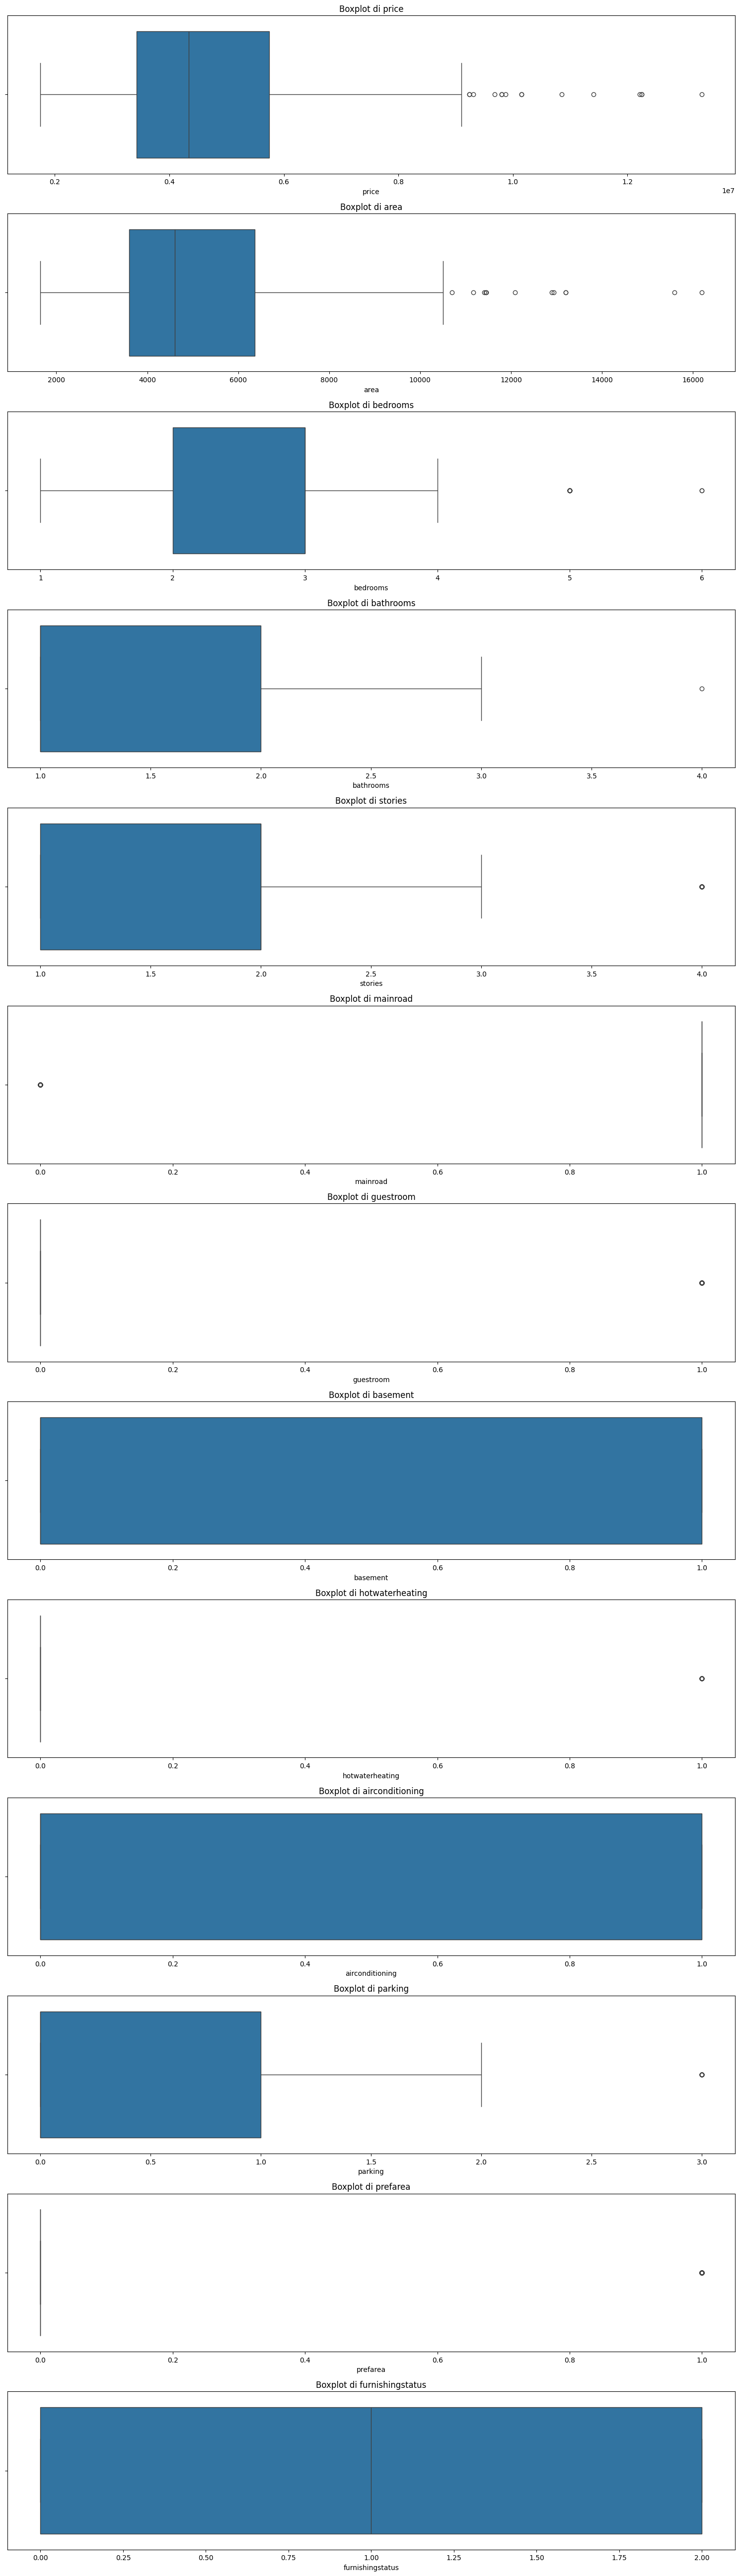

In [ ]:
visualizza_box_plot(df)

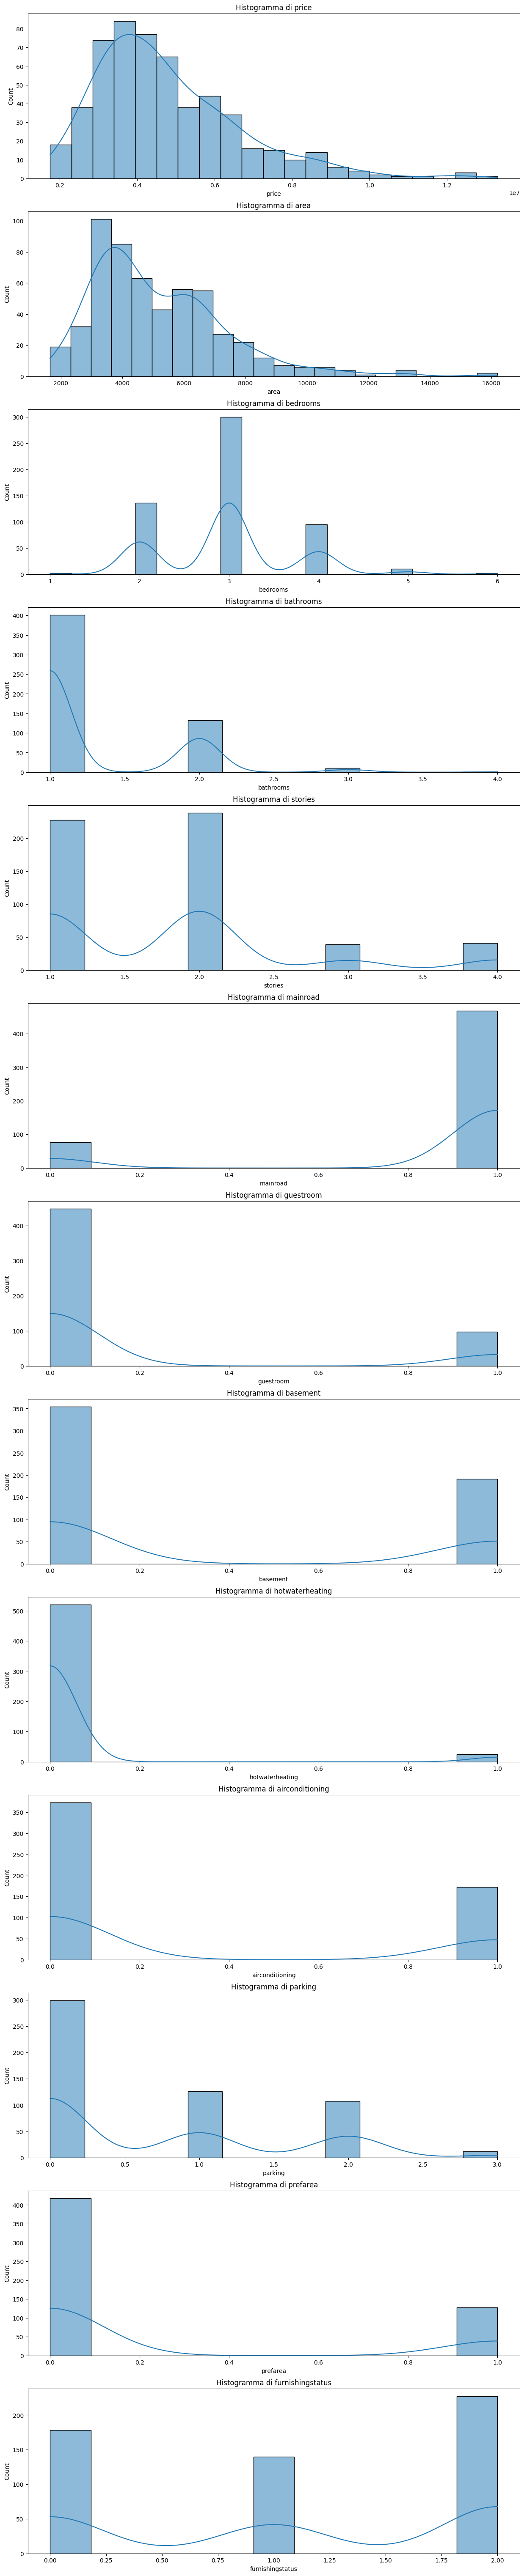

In [ ]:
visualizza_histogramma(df)

In [ ]:
def pre_processing(dataset):
    '''
        Questa funzione esegue una prima fase di esplorazione del dataset:
        - Visualizza le prime righe (head)
        - Mostra i nomi delle colonne
        - Riporta informazioni strutturali (tipi di dato, non-null count)
        - Genera statistiche descrittive per tutte le colonne
        - Verifica la presenza di valori mancanti
        - Applica la trasformazione ad alcune colonne
    '''
    print("-----HEAD-------")
    print(dataset.head(20))
    print("-----COLUMSN------")
    print(dataset.columns)
    print("-----INFO------")
    print(dataset.info())
    print("----DESCRIBE-------")
    print(dataset.describe(include="all").T)
    print("-----VALORI NULL------")
    print(dataset.isna().sum())



    dataset['price'] = np.log(dataset['price'])
    dataset['area'] = np.log(dataset['area'])
    dataset['area_x_bathrooms'] = dataset['area'] * dataset['bathrooms']
    dataset['area_x_bathrooms'] = np.log(dataset['area_x_bathrooms'])
    dataset = pd.get_dummies(dataset, columns=['bedrooms'], prefix='bed', drop_first=True)
    dataset = pd.get_dummies(dataset, columns=['stories'], prefix='stor', drop_first=True)
    dataset = pd.get_dummies(dataset, columns=['mainroad'], prefix='main', drop_first=True)
    dataset = pd.get_dummies(dataset, columns=['guestroom'], prefix='guest', drop_first=True)
    dataset = pd.get_dummies(dataset, columns=['basement'], prefix='main', drop_first=True)
    dataset = pd.get_dummies(dataset, columns=['airconditioning'], prefix='air', drop_first=True)
    dataset = pd.get_dummies(dataset, columns=['parking'], prefix='park', drop_first=True)
    dataset = pd.get_dummies(dataset, columns=['bathrooms'], prefix='bath', drop_first=True)
    dataset = pd.get_dummies(dataset, columns=['hotwaterheating'], prefix='hot', drop_first=True)
    dataset = pd.get_dummies(dataset, columns=['furnishingstatus'], prefix='fun', drop_first=True)
    dataset = pd.get_dummies(dataset, columns=['prefarea'], prefix='pref', drop_first=True)


    # Se hai altre variabili categoriche (es. 'mainroad', 'airconditioning')
    # puoi aggiungerle alla lista sopra
    return dataset
    '''

    '''


In [ ]:
data = pre_processing(df)

-----HEAD-------
       price   area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0   13300000   7420         4          2        3         1          0   
1   12250000   8960         4          4        4         1          0   
2   12250000   9960         3          2        2         1          0   
3   12215000   7500         4          2        2         1          0   
4   11410000   7420         4          1        2         1          1   
5   10850000   7500         3          3        1         1          0   
6   10150000   8580         4          3        4         1          0   
7   10150000  16200         5          3        2         1          0   
8    9870000   8100         4          1        2         1          1   
9    9800000   5750         3          2        4         1          1   
10   9800000  13200         3          1        2         1          0   
11   9681000   6000         4          3        2         1          1   
12   9310000   6550  

In [ ]:
def get_features(df):
    '''
        Questa funzione separa le feature dal target:
        - X contiene tutte le colonne eccetto 'price'
        - y contiene la colonna target 'price'
        Entrambi vengono restituiti come array numpy.
    '''
    X = df.drop(['price'],axis=1).values
    y = df['price'].values
    return X,y

In [ ]:
def standardizzazione_features(X_train,X_test):
    '''
    Questa funzione prende come argomenti le feature di train e di test
    - Esegue fit su le feature di train
    - Esegue la trasformazione delle feature di train e test
    In questo modo i dati vengono scalati evitando data lakeage garantendo coerenza tra train e test
    '''
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    return X_train,X_test

In [ ]:
def cross_validation(model,X_train,y_train,alpha_value,storage_dict,n_split=5):
    risultati_fold = {'r2': [],'mse': [],'residui': [],'coefficienti': []}
    kf = KFold(n_splits=n_split,shuffle=True,random_state=RANDOM_SEED)
    for train_index, val_index in kf.split(X_train):
        X_tr = X_train[train_index]
        X_val = X_train[val_index]
        y_tr = y_train[train_index]
        y_val = y_train[val_index]

        X_tr, X_val = standardizzazione_features(X_tr,X_val)
        # Fit sul train del fold
        model.fit(X_tr, y_tr)

        # Predizione sul validation del fold
        y_pred = model.predict(X_val)
        # Metriche

        risultati_fold['r2'].append(round(r2_score(y_val, y_pred), 3))
        risultati_fold['mse'].append(round(mean_squared_error(y_val, y_pred), 3))
        risultati_fold['residui'].append(y_val - y_pred)
        risultati_fold['coefficienti'].append(model.coef_)
        storage_dict[alpha_value] = risultati_fold
    return storage_dict


In [ ]:
X,y = get_features(data)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=RANDOM_SEED)

In [ ]:
cv_ridge = {}
for val_alpha in alphas:
    cv_ridge = cross_validation(Ridge(alpha=val_alpha),X_train,y_train,val_alpha,cv_ridge)



In [ ]:
cv_lasso = {}
for val_alpha in alphas:
     cv_lasso = cross_validation(Lasso(alpha=val_alpha),X_train,y_train,val_alpha,cv_lasso)


In [ ]:
cv_elastic = {}
for val_alpha in alphas:
     cv_elastic = cross_validation(ElasticNet(alpha=val_alpha,l1_ratio=0.5),X_train,y_train,val_alpha,cv_elastic)


In [ ]:
def valuta_modello(modello, X_test, y_test_log):
    '''
    Esegue la valutazione del modello riportando i prezzi alla scala originale.
    y_test_log: target in scala logaritmica
    '''
   # 1. Predizione (è in scala logaritmica perché il modello ha imparato quella)
    y_pred_log = modello.predict(X_test)

    # 2. Trasformazione INVERSA
    y_pred_euro = np.exp(y_pred_log)
    y_test_euro = np.exp(y_test_log)

    # 3. Calcolo metriche su scala reale
    mse = mean_squared_error(y_test_euro, y_pred_euro)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test_euro - y_pred_euro))

    # 4. R2 si calcola bene sulla scala logaritmica (indica la varianza spiegata)
    r2 = r2_score(y_test_log, y_pred_log)


    print(f"R2 Score: {r2:.4f}")
    print(f"MAE:      {mae:,.2f} €")
    print(f"RMSE:     {rmse:,.2f} €")

In [ ]:
best_alpha = min(cv_ridge, key=lambda a: np.mean(cv_ridge[a]['mse']))
best_alpha_lasso = min(cv_lasso, key=lambda a: np.mean(cv_lasso[a]['mse']))
best_alpha_elastic = min(cv_elastic, key=lambda a: np.mean(cv_elastic[a]['mse']))
print(f"RIDGE: {best_alpha}")
print(f"LASSO:      {best_alpha_lasso} ")
print(f"ELASTIC:     {best_alpha_elastic} ")

RIDGE: 10
LASSO:      0.01 
ELASTIC:     0.01 


In [ ]:
df = pd.read_csv("https://proai-datasets.s3.eu-west-3.amazonaws.com/housing.csv")
X,y = get_features(df)

In [ ]:
model_ridge = Ridge(alpha=best_alpha)
model_ridge.fit(X_train,y_train)
valuta_modello(model_ridge,X_test,y_test)

R2 Score: 0.6627
MAE:      877,021.84 €
RMSE:     1,216,849.81 €


In [ ]:
model_lasso = Lasso(alpha=best_alpha_lasso)
model_lasso.fit(X_train,y_train)
valuta_modello(model_lasso,X_test,y_test)

R2 Score: 0.5920
MAE:      969,372.67 €
RMSE:     1,332,355.88 €


In [ ]:
model_elastic = ElasticNet(alpha=best_alpha_elastic,l1_ratio=0.5)
model_elastic.fit(X_train,y_train)
valuta_modello(model_elastic,X_test,y_test)

R2 Score: 0.6334
MAE:      913,968.15 €
RMSE:     1,265,488.21 €


In [ ]:
def analisi_grafica_residui(residui,nome_modello):
    '''
      Questa funzione mostra il grafico dei residui
      su i vari modelli
    '''
    res = np.concatenate(residui)


    mu = np.mean(res)
    std = np.std(res)
    n = len(res)


    sns.set_theme(style="white")

    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")


    sns.histplot(res, kde=True, stat="density", color='skyblue', alpha=0.6, label='Densità Residui')


    x = np.linspace(mu - 4*std, mu + 4*std, 100)
    p = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / std)**2)
    plt.plot(x, p, color='red', lw=2, label='Normale Teorica')


    plt.axvline(mu, color='black', linestyle='--', alpha=0.8, label=f'Media: {mu:.4e}')


    plt.title(f'Distribuzione dei Residui {nome_modello}', fontsize=15)
    plt.xlabel('Valore del Residuo')
    plt.ylabel('Densità')
    plt.legend()

    plt.show()

    print(f"Analisi completata su {n} residui.")
    print(f"Media calcolata: {mu:.10f}")

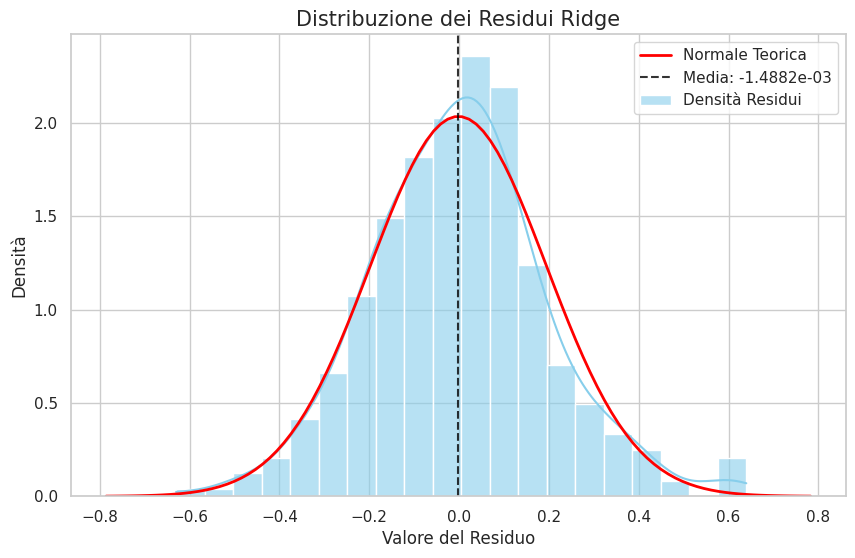

Analisi completata su 381 residui.
Media calcolata: -0.0014881891


In [ ]:
analisi_grafica_residui(cv_ridge[best_alpha]['residui'],'Ridge')

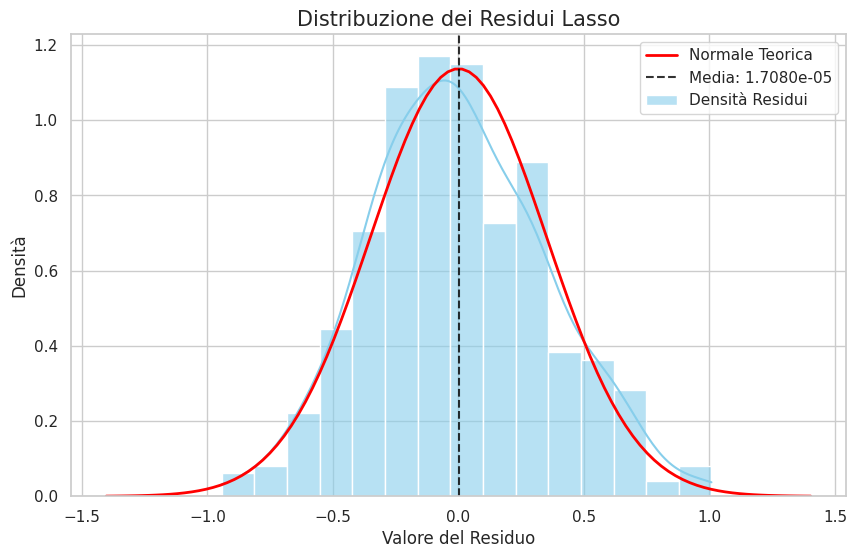

Analisi completata su 381 residui.
Media calcolata: 0.0000170802


In [ ]:
analisi_grafica_residui(cv_lasso[best_alpha]['residui'],'Lasso')

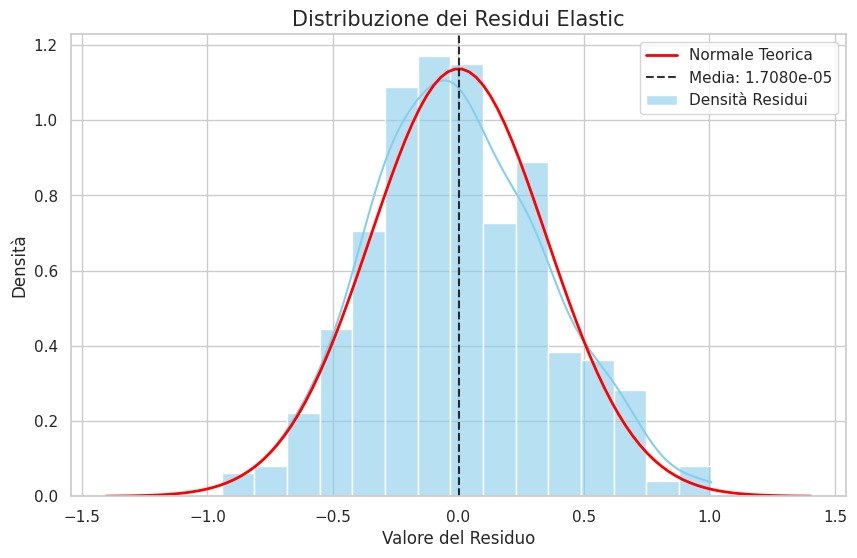

Analisi completata su 381 residui.
Media calcolata: 0.0000170802


In [ ]:
analisi_grafica_residui(cv_elastic[best_alpha]['residui'],'Elastic')

In [ ]:
def valori_coefficienti(modello,nome_modello):
    '''
      Questo grafico spiega come i modelli hanno utilizzato i coefficienti
    '''
    plt.figure(figsize=(10,6))
    plt.title(f"Valori coefficienti {nome_modello}")
    plt.bar(range(len(modello.coef_)), modello.coef_)
    plt.show()

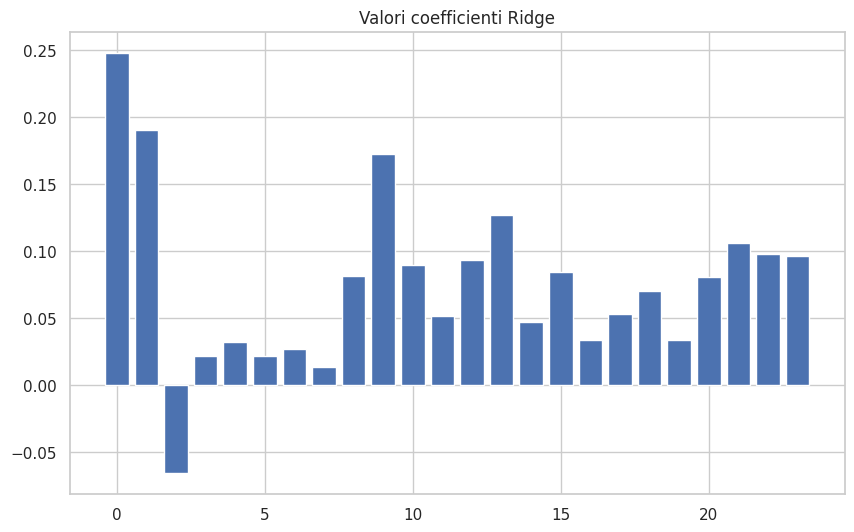

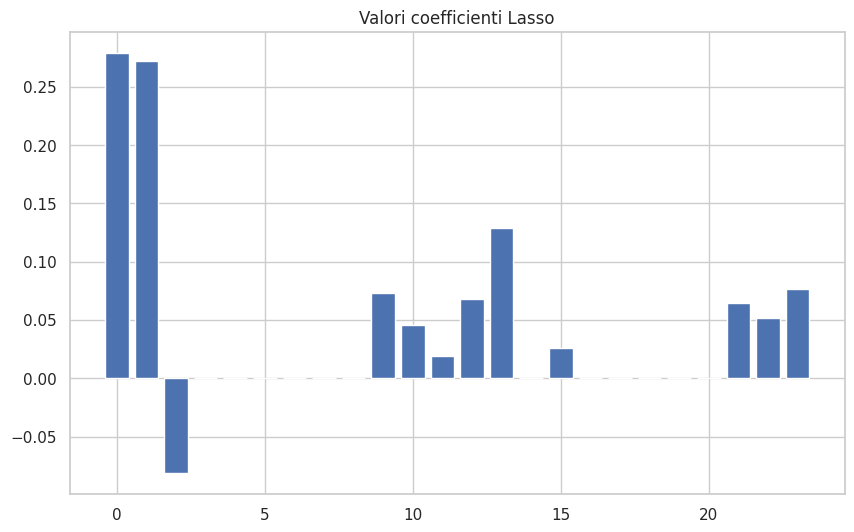

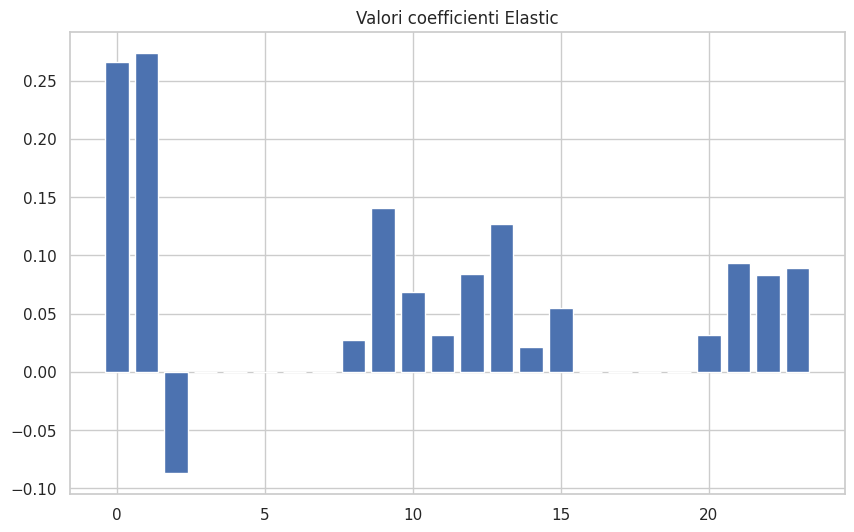

In [ ]:
valori_coefficienti(model_ridge,'Ridge')
valori_coefficienti(model_lasso,'Lasso')
valori_coefficienti(model_elastic,'Elastic')

In [ ]:
def grafico_residui(cv_dict, alpha_scelto,modello):
    '''
      Questo grafico spiega la distribuzione dei residui
      per i vari modelli
    '''
    residui = np.concatenate(cv_dict[alpha_scelto]['residui'])

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    sns.scatterplot(x=range(len(residui)), y=residui, alpha=0.5, color='steelblue')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f'Distribuzione Residui ({modello} alpha={alpha_scelto})')
    plt.xlabel('Indice Osservazione')
    plt.ylabel('Errore (Log Scale)')


    plt.subplot(1, 2, 2)
    sns.histplot(residui, kde=True, color='seagreen')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Densità dell\'Errore')
    plt.xlabel('Valore del Residuo')

    plt.tight_layout()
    plt.show()

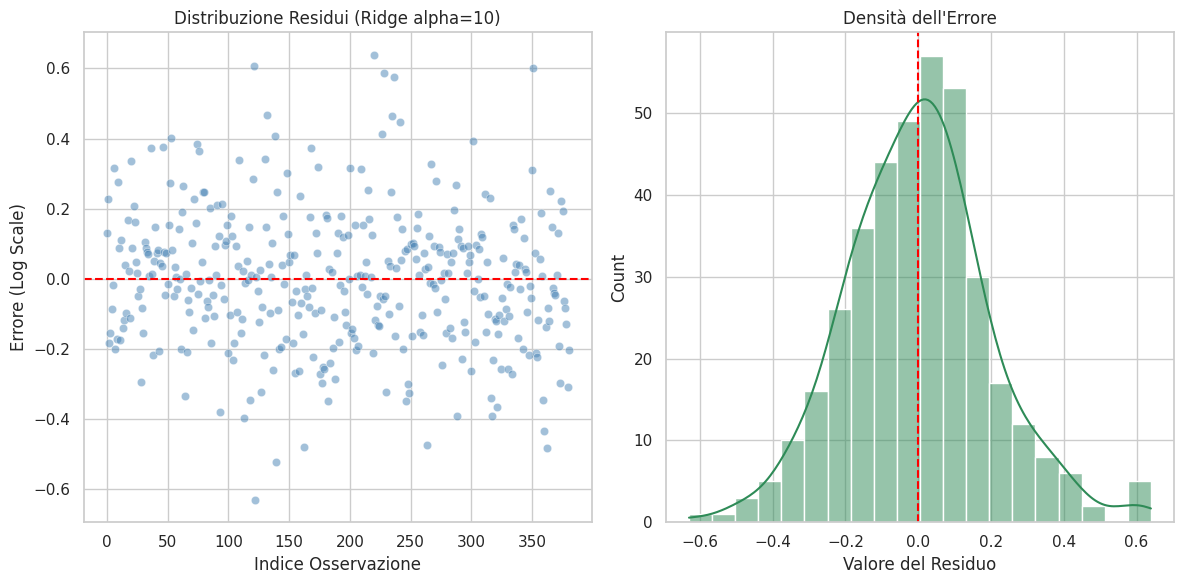

In [ ]:
grafico_residui(cv_ridge,best_alpha,'Ridge')

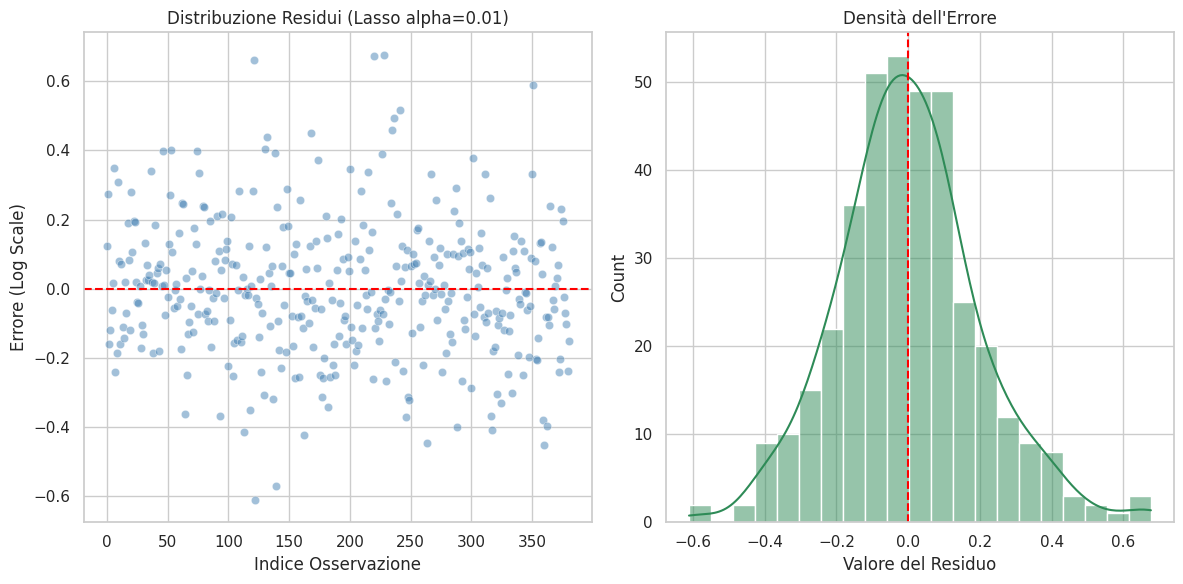

In [ ]:
grafico_residui(cv_lasso,best_alpha_lasso,'Lasso')

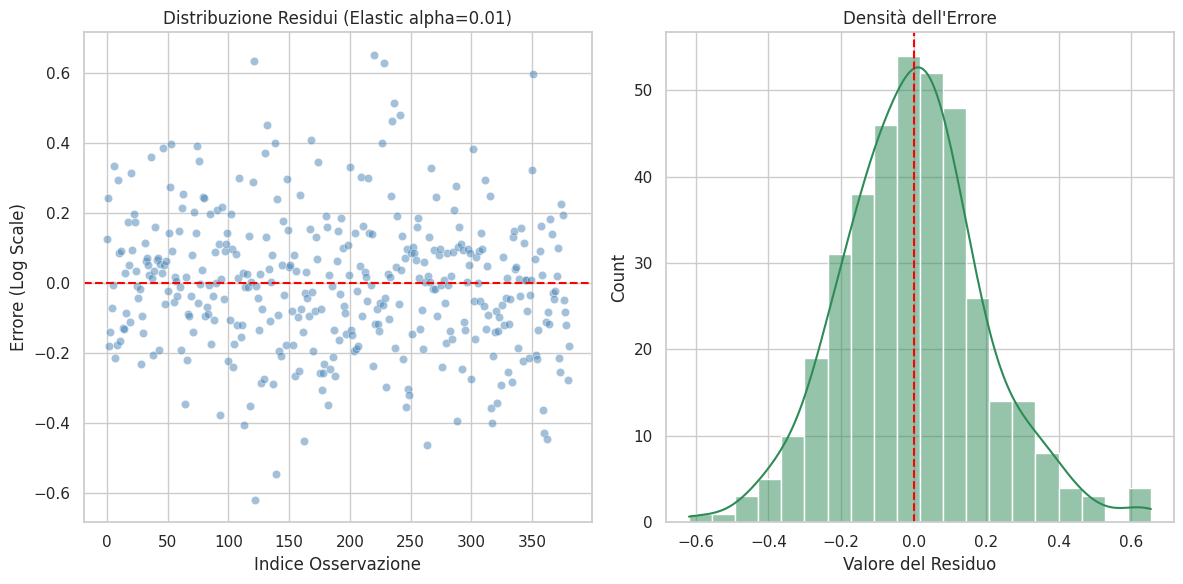

In [ ]:
grafico_residui(cv_elastic,best_alpha_elastic,'Elastic')

In [ ]:
def grafico_previsioni_reali(modello, X_test, y_test_log,name_modello):
    y_pred_log = modello.predict(X_test)


    y_reali_euro = np.exp(y_test_log)
    y_pred_euro = np.exp(y_pred_log)

    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_reali_euro, y=y_pred_euro, alpha=0.6)


    limiti = [y_reali_euro.min(), y_reali_euro.max()]
    plt.plot(limiti, limiti, color='red', linestyle='--', label='Perfezione')

    plt.title(f'Modello {name_modello} Prezzi Reali vs Prezzi Predetti (€)')
    plt.xlabel('Prezzo Reale (€)')
    plt.ylabel('Prezzo Predetto (€)')
    plt.legend()
    plt.grid(True)
    plt.show()

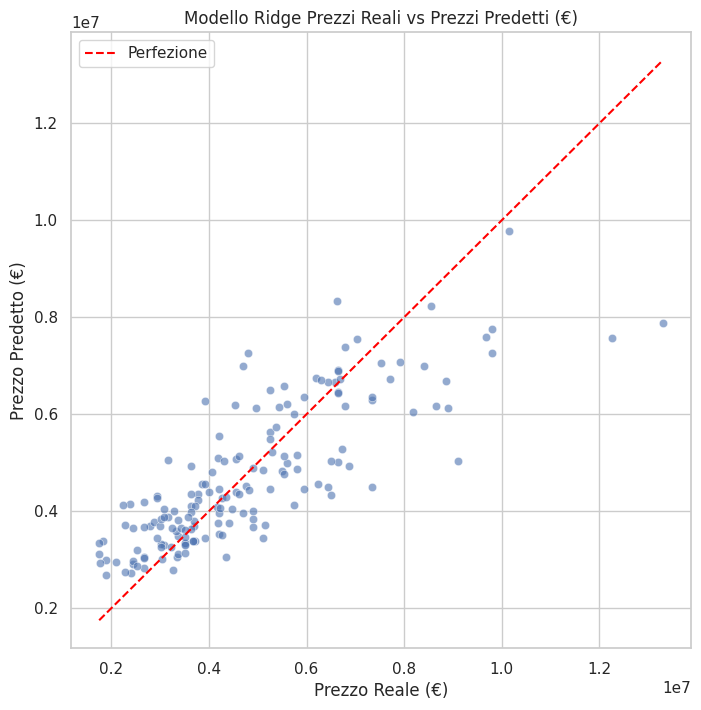

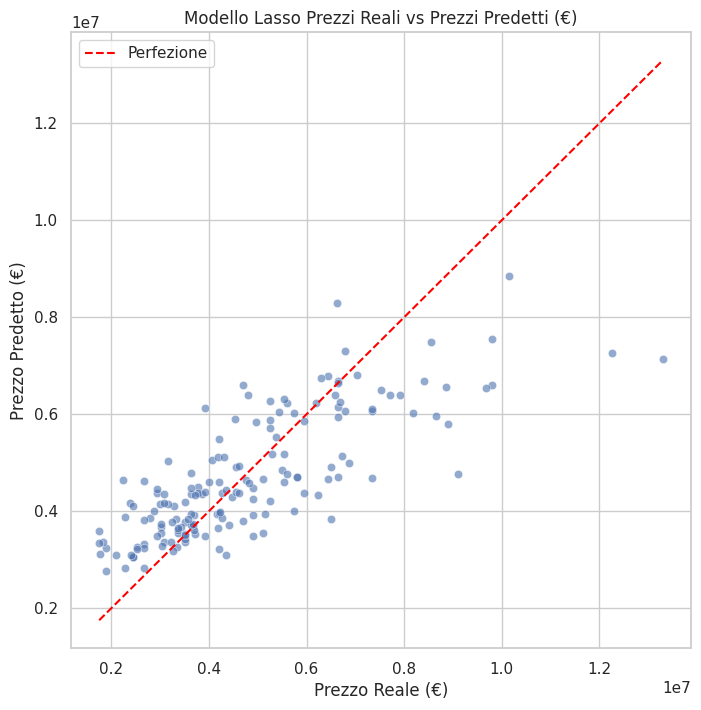

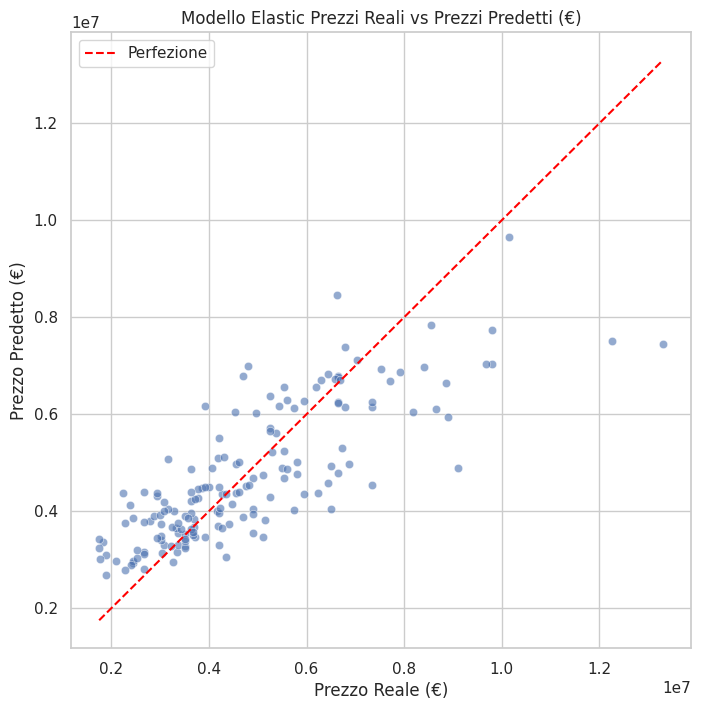

In [ ]:
grafico_previsioni_reali(model_ridge,X_test,y_test,'Ridge')
grafico_previsioni_reali(model_lasso,X_test,y_test,'Lasso')
grafico_previsioni_reali(model_elastic,X_test,y_test,'Elastic')